In [1]:
#Import neccesary libraries
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score,roc_auc_score, roc_curve, auc, precision_score
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

Using TensorFlow backend.


In [2]:
#Read Data
train = pd.read_csv('../input/train.csv', infer_datetime_format=True)
test = pd.read_csv('../input/test.csv', infer_datetime_format=True)
# des = pd.read_excel('./Data Dictionary.xlsx')

In [3]:
#Check train test 
print(train.shape)
print(test.shape)

#Drop duplicates
# test.drop_duplicates()
# No duplicates in data
# print(test.shape)


(233154, 41)
(112392, 40)


In [4]:
# train.isnull().sum()

In [5]:
# test.isna().sum()

In [6]:
# train.info()

In [7]:
train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [8]:
train.nunique()

UniqueID                               233154
disbursed_amount                        24565
asset_cost                              46252
ltv                                      6579
branch_id                                  82
supplier_id                              2953
manufacturer_id                            11
Current_pincode_ID                       6698
Date.of.Birth                           15433
Employment.Type                             2
DisbursalDate                              84
State_ID                                   22
Employee_code_ID                         3270
MobileNo_Avl_Flag                           1
Aadhar_flag                                 2
PAN_flag                                    2
VoterID_flag                                2
Driving_flag                                2
Passport_flag                               2
PERFORM_CNS.SCORE                         573
PERFORM_CNS.SCORE.DESCRIPTION              20
PRI.NO.OF.ACCTS                   

In [9]:
train.loan_default.value_counts()

0    182543
1     50611
Name: loan_default, dtype: int64

In [10]:
#Drop null values as this data is too sparse with 0 as most values
# train.dropna(inplace=True)
# test.dropna(inplace=True)
print(train.shape)
print(test.shape)
# print(train.isnull().sum().sum())

# print(test.isnull().sum().sum())

(233154, 41)
(112392, 40)


In [11]:
train.describe()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
count,233154.000000,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.0,233154.00000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000
mean,535917.573376,54356.993528,7.586507e+04,74.746530,72.936094,19638.635035,69.028054,3396.880247,7.262243,1549.477148,1.0,0.84032,0.075577,0.144943,0.023242,0.002127,289.462994,2.440636,1.039896,0.156549,1.659001e+05,2.185039e+05,2.180659e+05,0.059081,0.027703,0.007244,5.427793e+03,7.295923e+03,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615,0.217071
std,68315.693711,12971.314171,1.894478e+04,11.456636,69.834995,3491.949566,22.141304,2238.147502,4.482230,975.261278,0.0,0.36631,0.264320,0.352044,0.150672,0.046074,338.374779,5.217233,1.941496,0.548787,9.422736e+05,2.374794e+06,2.377744e+06,0.626795,0.316057,0.111079,1.702370e+05,1.831560e+05,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498,0.412252
min,417428.000000,13320.000000,3.700000e+04,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,476786.250000,47145.000000,6.571700e+04,68.880000,14.000000,16535.000000,48.000000,1511.000000,4.000000,713.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,535978.500000,53803.000000,7.094600e+04,76.800000,61.000000,20333.000000,86.000000,2970.000000,6.000000,1451.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,595039.750000,60413.000000,7.920175e+04,83.670000,130.000000,23000.000000,86.000000,5677.000000,10.000000,2362.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,678.000000,3.000000,1.000000,0.000000,3.500650e+04,6.250000e+04,6.080000e+04,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,671084.000000,990572.000000,1.628992e+06,95.000000,261.000000,24803.000000,156.000000,7345.000000,22.000000,3795.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,890.000000,453.000000,144.000000,25.000000,9.652492e+07,1.000000e+09,1.000000e+09,52.000000,36.000000,8.000000,3.603285e+07,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000,1.000000


In [12]:
test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


In [13]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d1,d2

def calc_number_of_ids(row):
#     print(type(row), row.size)
    return sum(row[['Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
       'Passport_flag']])

def check_pri_installment(row):
    if row['PRIMARY.INSTAL.AMT']<=1:
        return 0
    else:
        return row['PRIMARY.INSTAL.AMT']
    
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()


In [14]:
risk_map = {'No Bureau History Available':-1, 
              'Not Scored: No Activity seen on the customer (Inactive)':-1,
              'Not Scored: Sufficient History Not Available':-1,
              'Not Scored: No Updates available in last 36 months':-1,
              'Not Scored: Only a Guarantor':-1,
              'Not Scored: More than 50 active Accounts found':-1,
              'Not Scored: Not Enough Info available on the customer':-1,
              'Very Low Risk':4,
              'Low Risk':3,
              'Medium Risk':2, 
              'High Risk':1,
              'Very High Risk':0}

sub_risk = {'unknown':-1, 'I':5, 'L':2, 'A':13, 'D':10, 'M':1, 'B':12, 'C':11, 'E':9, 'H':6, 'F':8, 'K':3,
       'G':7, 'J':4}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:-1}

In [15]:
def features_engineering(df):
    print('feature engineering started')
    df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], format = "%d-%m-%y",infer_datetime_format=True)
    df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], format = "%d-%m-%y",infer_datetime_format=True)
    now = pd.Timestamp('now')
    df['Age'] = (now - df['Date.of.Birth']).astype('<m8[Y]').astype(int)
    age_mean = int(df[df['Age']>0]['Age'].mean())
    df.loc[:,'age'] = df['Age'].apply(lambda x: x if x>0 else age_mean)
    df['disbursal_months_passed'] = ((now - df['DisbursalDate'])/np.timedelta64(1,'M')).astype(int)
    df['average_act_age_in_months'] = df['AVERAGE.ACCT.AGE'].apply(lambda x : int(re.findall(r'\d+',x)[0])*12 + int(re.findall(r'\d+',x)[1]))
    df['credit_history_length_in_months'] = df['CREDIT.HISTORY.LENGTH'].apply(lambda x : int(re.findall(r'\d+',x)[0])*12 + int(re.findall(r'\d+',x)[1]))
    df['number_of_0'] = (df == 0).astype(int).sum(axis=1)
    
    df.loc[:,'credit_risk'],df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
    
    df.loc[:, 'loan_to_asset_ratio'] = df['disbursed_amount'] /df['asset_cost']
    df.loc[:,'no_of_accts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']

    df.loc[:,'pri_inactive_accts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
    df.loc[:,'sec_inactive_accts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
    df.loc[:,'tot_inactive_accts'] = df['pri_inactive_accts'] + df['sec_inactive_accts']
    df.loc[:,'tot_overdue_accts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
    df.loc[:,'tot_current_balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
    df.loc[:,'tot_sanctioned_amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
    df.loc[:,'tot_disbursed_amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
    df.loc[:,'tot_installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']
    df.loc[:,'bal_disburse_ratio'] = np.round((1+df['tot_disbursed_amount'])/(1+df['tot_current_balance']),2)
    df.loc[:,'pri_tenure'] = (df['PRI.DISBURSED.AMOUNT']/( df['PRIMARY.INSTAL.AMT']+1)).astype(int)
    df.loc[:,'sec_tenure'] = (df['SEC.DISBURSED.AMOUNT']/(df['SEC.INSTAL.AMT']+1)).astype(int)
#     df.loc[:,'tenure_to_age_ratio'] =  np.round((df['pri_tenure']/12)/df['age'],2)
    df.loc[:,'disburse_to_sactioned_ratio'] =  np.round((df['tot_disbursed_amount']+1)/(1+df['tot_sanctioned_amount']),2)
    df.loc[:,'active_to_inactive_act_ratio'] =  np.round((df['no_of_accts']+1)/(1+df['tot_inactive_accts']),2)
    print('done')
#     df.loc[:,'']
    return df

In [16]:
def label_data(df):
    print('labeling started')
    df.loc[:,'credit_risk_label'] = df['credit_risk'].apply(lambda x: risk_map[x])
    df.loc[:,'sub_risk_label'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])
    df.loc[:,'employment_label'] = df['Employment.Type'].apply(lambda x: employment_map[x])
    print('labeling done')
    return df

In [17]:
def data_correction(df):
    print('invalid data handling started')
    #Many customers have invalid date of birth, so immute invalid data with mean age
    df.loc[:,'PRI.CURRENT.BALANCE'] = df['PRI.CURRENT.BALANCE'].apply(lambda x: 0 if x<0 else x)
    df.loc[:,'SEC.CURRENT.BALANCE'] = df['SEC.CURRENT.BALANCE'].apply(lambda x: 0 if x<0 else x)
    
    #loan that do not have current pricipal outstanding should have 0 primary installment
    df.loc[:,'new_pri_installment']= df.apply(lambda x : check_pri_installment(x),axis=1)
    print('done')
    return df

In [18]:
def prepare_data(df):
    df = data_correction(df)
    df = features_engineering(df)
    df = label_data(df)

    return df
    

In [19]:
#Prepare training and test data
train_data = prepare_data(train)
train_data = train_data[train_data['number_of_0']<=25]
test_data = prepare_data(test)

invalid data handling started
done
feature engineering started
done
labeling started
labeling done
invalid data handling started
done
feature engineering started
done
labeling started
labeling done


In [20]:
train_data[train_data['number_of_0']>=20]['number_of_0'].value_counts()

25    33946
20     6650
22     6171
24     4347
21     2950
23      478
Name: number_of_0, dtype: int64

In [21]:
train_data.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'new_pri_installment', 'Age', 'age',
       'disbursal_months_passed', 'average_act_age_in_month

In [22]:
to_drop = ['UniqueID', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'PRIMARY.INSTAL.AMT',
       'PERFORM_CNS.SCORE.DESCRIPTION',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 
       'loan_default', 'Age',  'credit_risk', 'credit_risk_grade',
       ]
features = ['disbursed_amount', 'asset_cost',
            'Aadhar_flag', 'PAN_flag',
       'PERFORM_CNS.SCORE',
             'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT',  'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT',  'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
            'NO.OF_INQUIRIES','disbursal_months_passed',
       'average_act_age_in_months', 'credit_history_length_in_months',
       'number_of_0','loan_to_asset_ratio', 'no_of_accts', 'pri_inactive_accts',
       'sec_inactive_accts', 'tot_inactive_accts', 'tot_overdue_accts',
       'tot_current_balance', 'tot_sanctioned_amount', 'tot_disbursed_amount',
       'tot_installment', 'bal_disburse_ratio', 'pri_tenure', 'sec_tenure',
       'credit_risk_label',
       'employment_label', 'age', 'new_pri_installment'
           ]



In [23]:
print(train_data.shape)
print(test_data.shape)

(155754, 68)
(112392, 67)


In [24]:
from sklearn.preprocessing import  RobustScaler
# std_scaler = StandardScaler()
# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()

scaled_training = train_data.copy()
scaled_testing = test_data.copy()


scaled_training[features] = rob_scaler.fit_transform(scaled_training[features])
scaled_testing[features] = rob_scaler.fit_transform(scaled_testing[features])

y = scaled_training.loan_default
X = scaled_training[features]


In [25]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27,stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())
print(X_train.shape, y_train.shape)

(116815, 40) (116815,)
(38939, 40) (38939,)
(157714, 40) (157714,)


In [26]:
#  Prepare data for modeling
# Separate input features and target


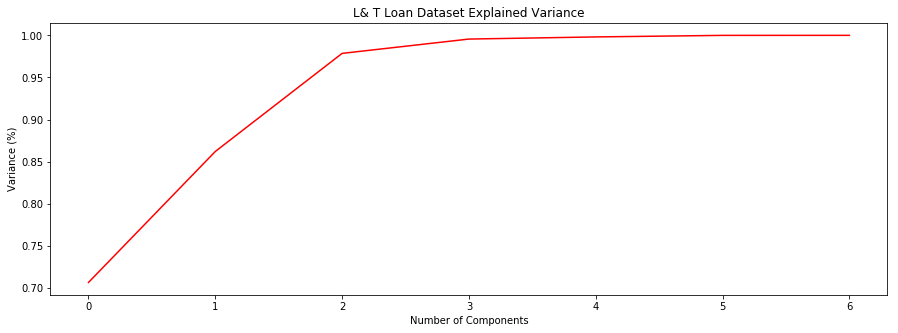

In [27]:
# plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
#Fitting the PCA algorithm with our Data
pca = PCA(n_components=7).fit(X)
X = pca.fit_transform(X)
X = pd.DataFrame(X, columns = ['p1','p2','p3','p4','p5','p6','p7'])
test_df = pd.DataFrame(pca.fit_transform(scaled_testing[features]), columns = ['p1','p2','p3','p4','p5','p6','p7'])
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(15,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('L& T Loan Dataset Explained Variance')
plt.show()

In [28]:
X.shape

(155754, 7)

In [29]:
# # setting up testing and training sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27,stratify=y)

In [30]:
train.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'new_pri_installment', 'Age', 'age',
       'disbursal_months_passed', 'average_act_age_in_month

In [31]:
# test['number_of_0'].value_counts()
# Drop row having more than 50 % data as 0
# train_data = train[train['number_of_0']<=20]
# test_data = test[test['number_of_0']<=20]
# train_data = train.copy()
# test_data = test.copy()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


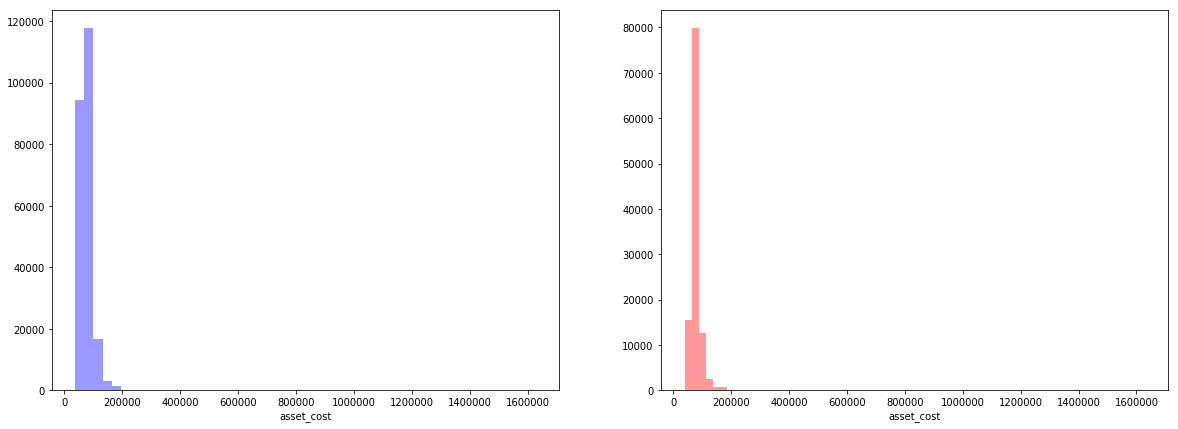

In [32]:
f, axes = plt.subplots(1,2 , figsize=(20, 7), sharex=True)
# sns.despine(left=True)
sns.distplot(train['asset_cost'],kde = False, color="b", ax=axes[0])
sns.distplot(test['asset_cost'],kde = False, color="r", ax=axes[1])


# plt.pyplot.setp(axes, yticks=[])
# plt.pyplot.tight_layout()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


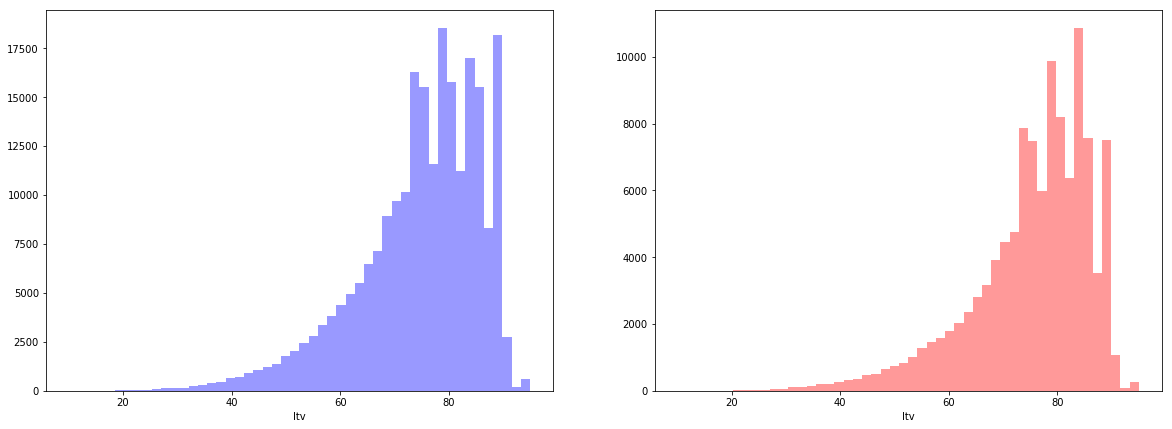

In [33]:
f, axes = plt.subplots(1,2 , figsize=(20, 7), sharex=True)
# sns.despine(left=True)
sns.distplot(train['ltv'],kde = False, color="b", ax=axes[0])
sns.distplot(test['ltv'],kde = False, color="r", ax=axes[1])
# train['ltv'].value_counts()

Text(0.5, 1.0, 'Aadhar=0')

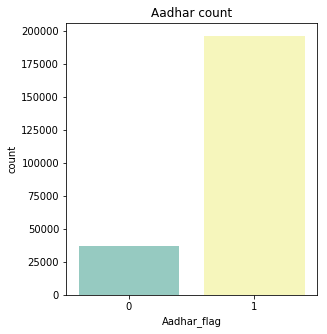

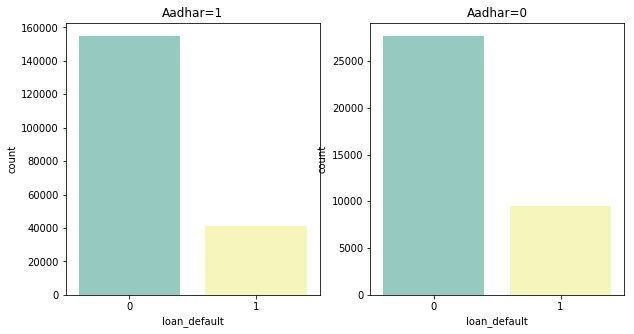

In [34]:
fig, ax =plt.subplots(1,1,figsize=(4.5, 5))
sns.countplot(train['Aadhar_flag'],  palette="Set3").set_title('Aadhar count')
fig, ax =plt.subplots(1,2,figsize=(10, 5))
# fig, ax =plt.subplots(2,2,figsize=(10, 10))
# sns.countplot(train['Aadhar_flag'], ax=ax[0,0],  palette="Set3")
# sns.countplot(test['Aadhar_flag'], ax=ax[0,1],  palette="Set3")
sns.countplot(train[train['Aadhar_flag']==1]['loan_default'], ax=ax[0], palette="Set3").set_title('Aadhar=1')
sns.countplot(train[train['Aadhar_flag']==0]['loan_default'], ax=ax[1],  palette="Set3").set_title('Aadhar=0')

Text(0.5, 1.0, 'PAN=0')

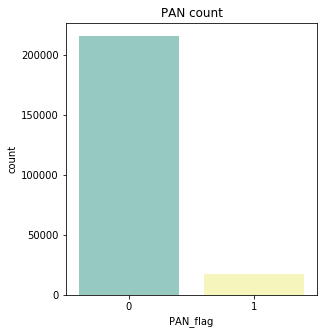

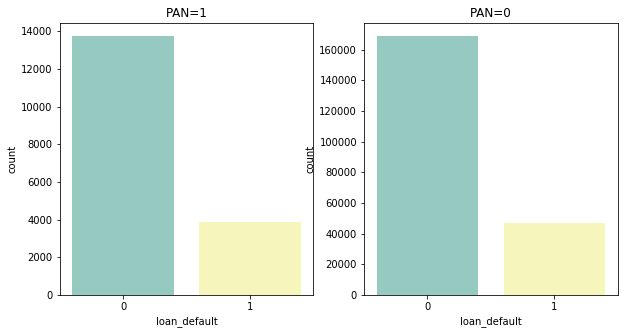

In [35]:
fig, ax =plt.subplots(1,1,figsize=(4.5, 5))
sns.countplot(train['PAN_flag'],  palette="Set3").set_title('PAN count')
fig, ax =plt.subplots(1,2,figsize=(10, 5))
# sns.countplot(test['PAN_flag'], ax=ax[0,1] ,palette="Set3")
# sns.countplot(train[train['PAN_flag']==1]['loan_default'], ax=ax[0,0],palette="Set3").set_title("LaLaLa")
# sns.countplot(train[train['PAN_flag']==0]['loan_default'], ax=ax[0,1],palette="Set3")
sns.countplot(train[train['PAN_flag']==1]['loan_default'], ax=ax[0],palette="Set3").set_title("PAN=1")
sns.countplot(train[train['PAN_flag']==0]['loan_default'], ax=ax[1],palette="Set3").set_title("PAN=0")

Text(0.5, 1.0, 'VoterID=0')

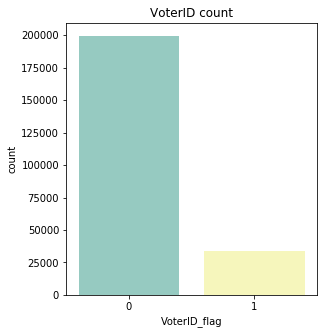

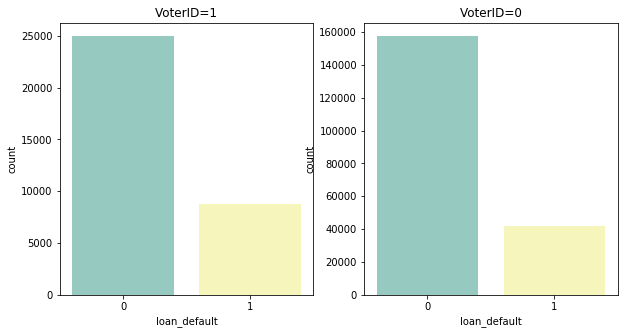

In [36]:
fig, ax =plt.subplots(1,1,figsize=(4.5, 5))
sns.countplot(train['VoterID_flag'],  palette="Set3").set_title('VoterID count')
fig, ax =plt.subplots(1,2,figsize=(10, 5))
# sns.countplot(test['PAN_flag'], ax=ax[0,1] ,palette="Set3")
# sns.countplot(train[train['PAN_flag']==1]['loan_default'], ax=ax[0,0],palette="Set3").set_title("LaLaLa")
# sns.countplot(train[train['PAN_flag']==0]['loan_default'], ax=ax[0,1],palette="Set3")
sns.countplot(train[train['VoterID_flag']==1]['loan_default'], ax=ax[0],palette="Set3").set_title("VoterID=1")
sns.countplot(train[train['VoterID_flag']==0]['loan_default'], ax=ax[1],palette="Set3").set_title("VoterID=0")
#######
# fig, ax =plt.subplots(2,2,figsize=(10, 10))
# sns.countplot(train['VoterID_flag'], ax=ax[0,0])
# sns.countplot(test['VoterID_flag'], ax=ax[0,1])
# sns.countplot(train[train['VoterID_flag']==1]['loan_default'], ax=ax[1,0])
# sns.countplot(train[train['VoterID_flag']==0]['loan_default'], ax=ax[1,1])

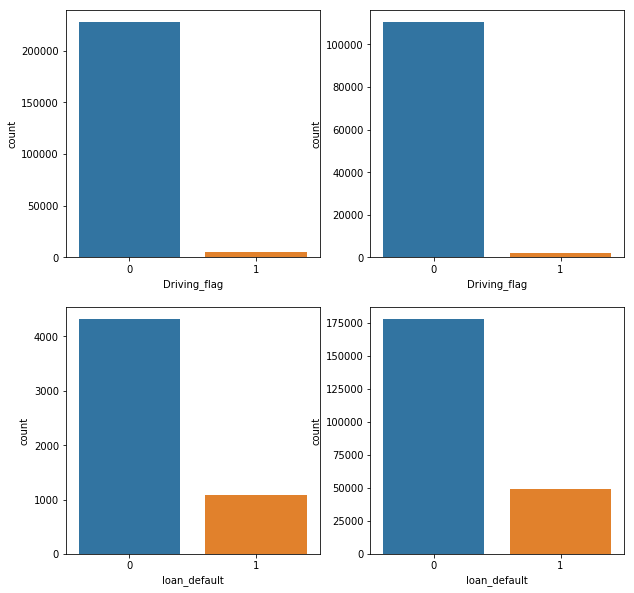

In [37]:
fig, ax =plt.subplots(2,2,figsize=(10, 10))
sns.countplot(train['Driving_flag'], ax=ax[0,0])
sns.countplot(test['Driving_flag'], ax=ax[0,1])
sns.countplot(train[train['Driving_flag']==1]['loan_default'], ax=ax[1,0])
sns.countplot(train[train['Driving_flag']==0]['loan_default'], ax=ax[1,1])

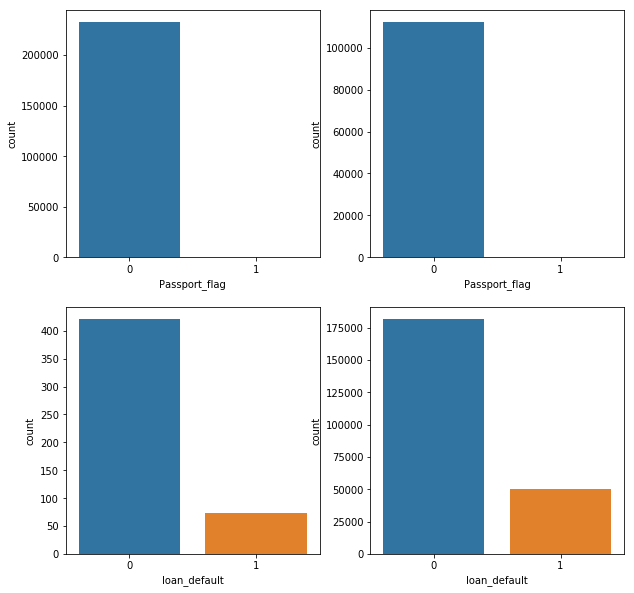

In [38]:
fig, ax =plt.subplots(2,2,figsize=(10, 10))
sns.countplot(train['Passport_flag'], ax=ax[0,0])
sns.countplot(test['Passport_flag'], ax=ax[0,1])
sns.countplot(train[train['Passport_flag']==1]['loan_default'], ax=ax[1,0])
sns.countplot(train[train['Passport_flag']==0]['loan_default'], ax=ax[1,1])

In [39]:
def train_model(model):
    # Checking accuracy
    model = model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('accuracy_score',accuracy_score(y_test, pred))
    print('precision_score',precision_score(y_test, pred))
    print('recall_score',recall_score(y_test, pred))
    print('f1_score',f1_score(y_test, pred))
    print('roc_auc_score',roc_auc_score(y_test, pred))
    # confusion matrix
    print('confusion_matrix')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    return model

In [40]:
# Modeling the data as is
# Train model
# xgb = XGBClassifier()

# xgb = train_model(xgb)

In [41]:
# from xgboost import plot_importance
# from matplotlib import pyplot
# # plot feature importance
# plot_importance(xgb)
# pyplot.show()

In [42]:
# train model
rfc = RandomForestClassifier()
rfc = train_model(rfc)
# predict on test set


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy_score 0.9096021983101774
precision_score 0.9209919793491288
recall_score 0.7895360784003793
f1_score 0.8502127659574468
roc_auc_score 0.8784665859551163
confusion_matrix
       0     1
0  25429   857
1   2663  9990


In [43]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf = train_model(dt_clf)

accuracy_score 0.9513084568170729
precision_score 0.9226054844032372
recall_score 0.9280012645222477
f1_score 0.9252955082742317
roc_auc_score 0.9452644228720954
confusion_matrix
       0      1
0  25301    985
1    911  11742


In [44]:
d_train = lgb.Dataset(X_train, label=y_train)
params = {}

params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

In [45]:
pred=clf.predict(X_test)
for i in range(len(pred)):
    if pred[i]>=.4:       # setting threshold to .5
        pred[i]=1
    else:  
        pred[i]=0
print('accuracy_score',accuracy_score(y_test, pred))
print('recall_score',recall_score(y_test, pred))
print('f1_score',f1_score(y_test, pred))
print('roc_auc_score',roc_auc_score(y_test, pred))
# confusion matrix
print('confusion_matrix')
print(pd.DataFrame(confusion_matrix(y_test, pred)))

accuracy_score 0.9147127558488919
recall_score 0.8665929028688848
f1_score 0.8684804562195556
roc_auc_score 0.902234289066642
confusion_matrix
       0      1
0  24653   1633
1   1688  10965


In [46]:
# f = ['p1','p2','p3','p4','p5']
# fi = xgb.feature_importances_
# rfi = rfc.feature_importances_
# xgbfi = pd.DataFrame({'features':f,'xgb_importance':fi, 'rf_importance':rfi})
# xgbfi.sort_values(by=['rf_importance'],ascending=False)

In [47]:
# best_parameters = gd_sr.best_params_  
# print(best_parameters)  

In [48]:
# best_result = gd_sr.best_score_  
# print(best_result)  

In [49]:
unique_id = scaled_testing.UniqueID
y_pred_rf = rfc.predict(scaled_testing[features])
submission1 = pd.DataFrame({'UniqueID': unique_id,'loan_default': y_pred_rf})
submission1.head()

# unique_id = testing.UniqueID
# y_pred_rf = xgb.predict(testing.drop(to_drop_test, axis=1))
# submission2 = pd.DataFrame({'UniqueID': unique_id,'loan_default': y_pred_rf})
# submission2.head()



,UniqueID,loan_default
0,655269,0
1,723482,1
2,758529,0
3,763449,0
4,708663,0


In [50]:
filename = 'submission_rf.csv'

submission1.to_csv(filename,index=False)

print('Saved file: ' + filename)

# filename1 = 'submission_xgb.csv'

# submission2.to_csv(filename1,index=False)

# print('Saved file: ' + filename1)

Saved file: submission_rf.csv
